In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_formats = ['svg']


In [2]:
df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# Non-VVSG equipment
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable',
                        'Internet Voting: Email',
                        'Internet Voting: Web Portal',
                        'Internet Voting: Fax',
                        'Remote Ballot Marking System: Client-Side',
                        'Remote Ballot Marking System: Server-Side']

# VVSG equipment
voting_equipment = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment)]

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'


/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_52250/2523839001.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


In [3]:
blue = '#3C608A'
lightgray = '#d3d8d6'
darkblue = '#2e4465'
bpc_darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'
mustard = '#D4AD50'
purple = '#5E233B'
pink = '#F87FAB'

# New equipment acquisitions

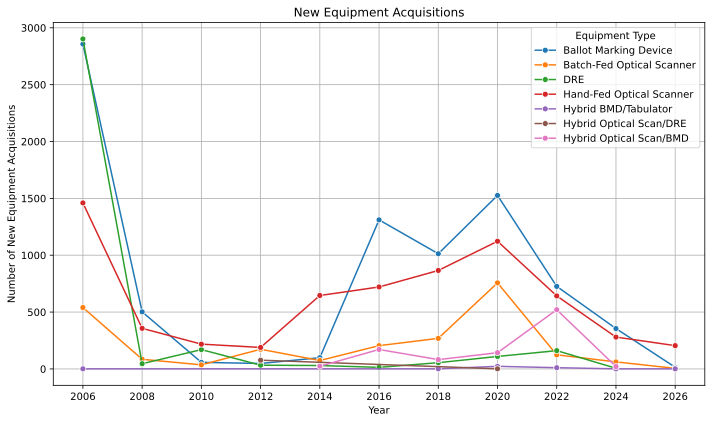

In [4]:
# Group by year and equipment type, and count
df_grouped = df[df['New Equipment']].groupby(['Year', 'Equipment Type']).size().reset_index(name='Count')

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='Year', y='Count', hue='Equipment Type', marker='o')

plt.title('New Equipment Acquisitions')
plt.xlabel('Year')
plt.ylabel('Number of New Equipment Acquisitions')
plt.xticks(sorted(df['Year'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()


# Compare age of current equipment to typical age at retirement (weighted by N registered voters)

In [5]:
# sanity check on N voters before using it to calculate weighted average
n = df[df['Year']==2026].drop_duplicates(subset='FIPS code', keep='first')['Registered Voters'].sum()
f"{n:,} registered voters across jurisdictions with voting equipment in 2026"

# https://www.eac.gov/sites/default/files/2024-11/2022_EAVS_Report_508c.pdf#page=6
# "More than 203 million individuals were
# active registered voters for the 2022 general election,"
# this is close enough, i think! sanity check passed

'221,877,727 registered voters across jurisdictions with voting equipment in 2026'

In [6]:
# Function to calculate weighted average and weighted std
def weighted_stats(group):
    weights = group["Registered Voters"]
    values = group["Years in Use"]
    
    # Weighted average
    avg = np.average(values, weights=weights)
    
    # Weighted standard deviation
    variance = np.average((values - avg)**2, weights=weights)
    std_dev = np.sqrt(variance)

    N = len(group)
    
    return pd.Series({
        "Weighted Avg Age": avg,
        "Weighted Std Age": std_dev,
        "N": N
    })

filtered_df = df.dropna(subset=['Registered Voters', 'Years in Use', 'Equipment Type'])
# Apply function by Equipment Type
age_at_retirement = filtered_df[filtered_df['Final Year in Use']==True].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

# View result
age_at_retirement

current_age = filtered_df[filtered_df['Year'] == 2026].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

retirement_df = pd.merge(current_age, age_at_retirement, on='Equipment Type', how='left', suffixes=(' Current', ' At Retirement'))
retirement_df = retirement_df.loc[[3, 1, 0, 2, 5, 4]].reset_index(drop=True)
retirement_df

,Equipment Type,Weighted Avg Age Current,Weighted Std Age Current,N Current,Weighted Avg Age At Retirement,Weighted Std Age At Retirement,N At Retirement
0,Hand-Fed Optical Scanner,7.709679,4.603530,4311.0,9.167242,5.369100,5940.0
1,Batch-Fed Optical Scanner,6.866530,2.659425,1509.0,8.606958,4.927230,1274.0
2,Ballot Marking Device,7.404515,3.978094,4997.0,7.596795,5.590565,3513.0
3,DRE,13.284889,8.140713,401.0,9.068539,5.900147,4508.0
4,Hybrid Optical Scan/BMD,7.962878,2.683616,938.0,2.151545,1.358640,24.0
5,Hybrid BMD/Tabulator,4.672151,1.748084,34.0,0.774858,0.974326,4.0


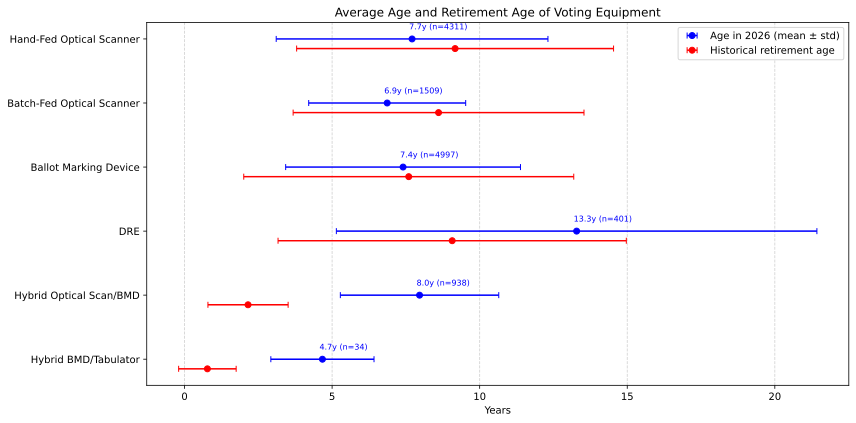

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
y = np.arange(len(retirement_df))

# Plot current age
ax.errorbar(retirement_df['Weighted Avg Age Current'], y, xerr=retirement_df['Weighted Std Age Current'],
            fmt='o', color='blue', label='Age in 2026 (mean ± std)', capsize=3)

# Annotate current age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age Current']:.1f}y (n={int(row['N Current'])})"
    ax.text(row['Weighted Avg Age Current'] - 0.1, y[i] - 0.15, label, color='blue', fontsize=8)

# Plot retirement age
for i, row in retirement_df.iterrows():
    if pd.notnull(row['Weighted Avg Age At Retirement']):
        label = 'Historical retirement age' if i == 0 else ''
        ax.errorbar(row['Weighted Avg Age At Retirement'], y[i] + 0.15,
                    xerr=row['Weighted Std Age At Retirement'], fmt='o', label=label,
                    color='red', capsize=3)

# Formatting
ax.set_yticks(y)
ax.set_yticklabels(retirement_df['Equipment Type'])
ax.invert_yaxis()  # So first row is on top
ax.set_xlabel('Years')
ax.set_title('Average Age and Retirement Age of Voting Equipment')
ax.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Histogram of equipment age

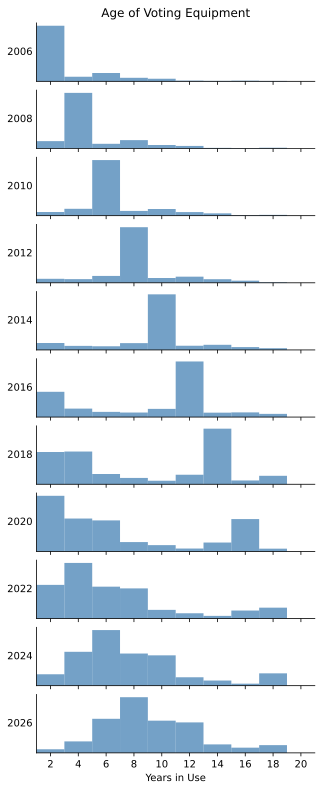

In [104]:
years = sorted(df["Year"].unique())
n_years = len(years)

# Set up one figure with subplots
fig, axes = plt.subplots(n_years, 1, figsize=(5, 1.2 * n_years), sharex=True)

global_xmin, global_xmax = df["Years in Use"].min(), df["Years in Use"].max()
xlim = [0, 20]
xticks = np.arange(1, xlim[1], step=2)
xtick_labels = xticks + 1

for i, (year, ax) in enumerate(zip(years, axes)):
    y = df[df["Year"] == year]["Years in Use"]
    sns.histplot(y, bins=np.arange(0, 20, 2), ax=ax, color='steelblue', edgecolor='none')
    sns.despine()

    ax.set_xlim(xlim)
    ax.set_yticks([])  # Remove y-axis
    ax.set_ylabel(f"{year}", rotation=0, ha="right", va="center")
    ax.set_xlabel("Years in Use")

    if i == 0:
        ax.set_title("Age of Voting Equipment")

    # Only show x-axis tick labels on bottom plot
    if i == n_years - 1:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)

# Tight layout with minimal vertical space
plt.subplots_adjust(hspace=0.15)
# plt.tight_layout()
plt.show()


# Histogram of equipment age (smooth)

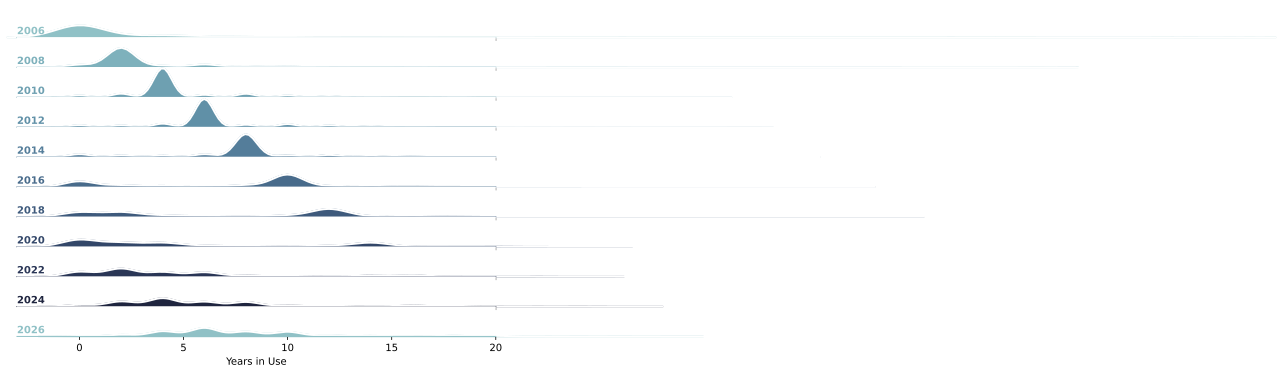

In [ ]:
# using sample seaborn code https://seaborn.pydata.org/examples/kde_ridgeplot

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Year", hue="Year", aspect=15, height=.5, palette=pal)

bw_adjust = 1 # smoothing

g.map(sns.kdeplot, "Years in Use",
      bw_adjust=bw_adjust, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Years in Use", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, "Years in Use")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlim=(-3, 20))
g.despine(bottom=True, left=True)

# todo: make this a series of plain unsmoothed histograms?
# make population weighted?


# Average age of equipment in 2026

In [112]:
voting_df_26 = df[df["Year"]==2026]
state_eq_len = pd.DataFrame(voting_df_26.groupby(["State"])["Years in Use"].mean())
state_eq_len.sort_values(["Years in Use"], ascending=False).round(1)

,Years in Use
State,
Oklahoma,14.0
Puerto Rico,14.0
Louisiana,13.8
Massachusetts,13.5
Indiana,13.0
Tennessee,10.6
Maine,10.3
Maryland,10.0
Northern Mariana Islands,10.0


# Age of equipment over time

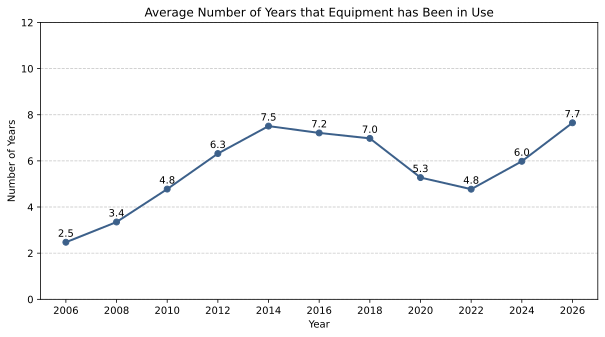

In [46]:
years_in_use = df.groupby(["Year"])["Years in Use"].mean().reset_index()

# Ensure "Year" is treated as numeric
years_in_use["Year"] = years_in_use["Year"].astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Years in Use"]):
    ax.text(years_in_use["Year"][i], value+.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/avg_years_in_use.png")
plt.show()

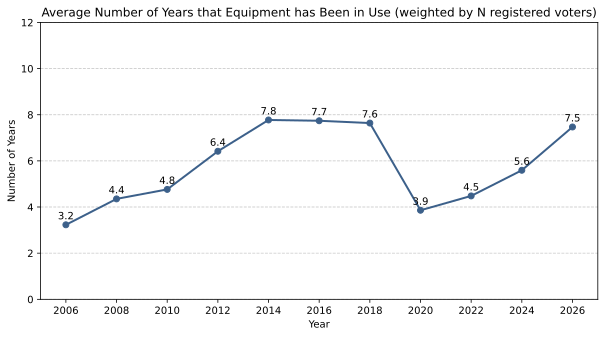

In [47]:
# Compute weighted average years in use per year
filtered_voting_df = df.dropna(subset=["Years in Use", "Registered Voters"])

years_in_use = (
    filtered_voting_df.groupby("Year")
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Registered Voters"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)

# Ensure "Year" is treated as numeric
years_in_use["Year"] = years_in_use["Year"].astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Weighted Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Weighted Years in Use"]):
    ax.text(years_in_use["Year"][i], value + 0.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use (weighted by N registered voters)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/weighted_avg_years_in_use.png")
plt.show()


When new voting equipment infusions happen

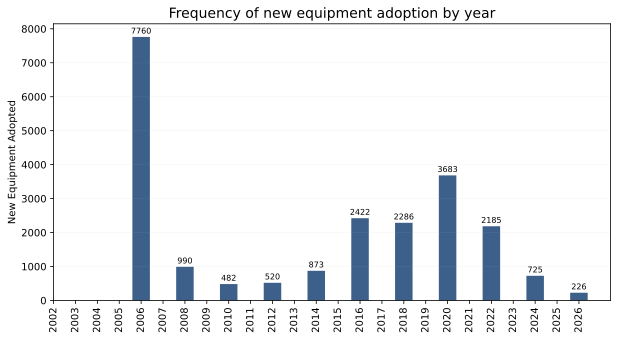

In [48]:
year_enacted = [2002, 2018, 2020, 2020, 2022, 2023, 2024, 2025,2026]
federal_funding_millions = [3650, 380, 400, 425, 75, 75, 55, 15,0]

# Compute new equipment counts per year
new_equipment_counts = df.groupby("Year")["New Equipment"].sum()

# Convert index to integers for consistent plotting
new_equipment_counts.index = new_equipment_counts.index.astype(int)

# Ensure all years are included in the x-axis range
all_years = np.arange(min(year_enacted), max(year_enacted) + 1)

# Align federal funding with years
funding_dict = dict(zip(year_enacted, federal_funding_millions))
funding_values = [funding_dict.get(year, 0) for year in all_years]  # Fill missing years with 0

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.grid(axis="y", linestyle="-", alpha=0.1)

# Primary y-axis (New Equipment Adoption)
ax1.bar(new_equipment_counts.index, new_equipment_counts, color=blue)
ax1.set_ylabel("New Equipment Adopted")

# Add data labels
for year, value in new_equipment_counts.items():
    ax1.text(year, value + 100, str(value), ha="center", fontsize=8)

# Secondary y-axis (Federal Funding)
# ax2 = ax1.twinx()
# ax2.bar(all_years, funding_values, color=pink, alpha=0.6, label="Federal Funding ($M)", width=0.6)
# ax2.set_ylabel("Federal Funding (Millions $)", fontsize=12, color="gray")
# ax2.tick_params(axis="y", labelcolor="gray")

# Set x-axis to show all years
ax1.set_xticks(all_years)
ax1.set_xticklabels(all_years, rotation=90)

# Titles & Legends
ax1.set_title("Frequency of new equipment adoption by year", fontsize=14)
plt.savefig("figs/new_eq_freq_gap.png")
plt.show()